In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
from tqdm.auto import tqdm

In [2]:
sns.set()
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from sir_models.seir import SEIR
from sir_models.utils import stepwise

# Load data

In [6]:
df = pd.read_csv('data/data.csv', sep=';')

In [7]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

df['infected'] = df['total_infected'] - df['total_recovered'] - df['total_dead']

In [8]:
df = df[df.region == 'Москва'].reset_index()
#df = df.groupby('date').sum().reset_index()

In [9]:
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected
0,40,2020-03-12,Москва,21,0,0,0,21,0,21
1,122,2020-03-13,Москва,26,0,0,0,5,0,26
2,204,2020-03-14,Москва,35,0,0,0,9,0,35
3,286,2020-03-15,Москва,35,1,0,0,0,1,34
4,368,2020-03-16,Москва,53,1,0,0,18,0,52


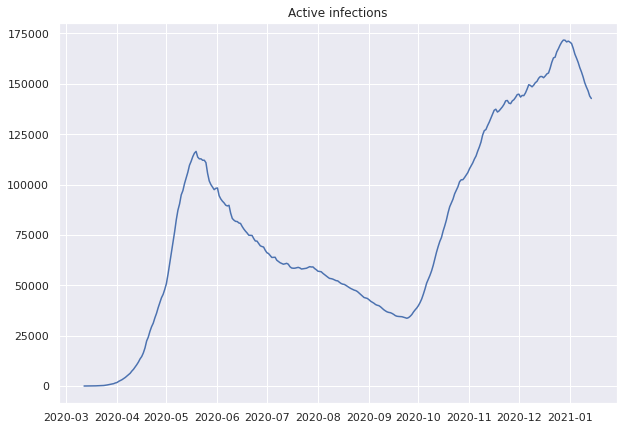

In [10]:
plt.figure(figsize=(10,7))
plt.plot(df.date, df.infected)
plt.title("Active infections")
plt.show()

# Model

In [11]:
train_subset = df[(df.date >= '2020-03-25') & (df.date <= '2020-11-30')]

In [12]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

264   2020-12-01
265   2020-12-02
266   2020-12-03
Name: date, dtype: datetime64[ns]

In [13]:
model = SEIR()
model.fit(train_subset)

Getting initial conditions
Optimizing params
mae 204.45947595560068
mae 204.45947595560068
mae 204.45947595560068
mae 204.45913742963612
mae 204.45934363655
mae 204.4594324258969
mae 204.45946771689847
mae 204.45947568980822
mae 209.9819840628156
mae 204.37781945632946
mae 204.3777873306048
mae 204.37771628549584


KeyboardInterrupt: 

In [ ]:
(S, E, I, R, D), history = model.predict_train()

result = model.fit_result_
result

In [ ]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, I, label='infected')
plt.plot(train_subset.date, E, label='exposed')
plt.plot(train_subset.date, D, label='dead')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(history.new_infected, label='daily infected')
plt.plot(history.new_dead, label='daily deaths')
plt.plot(history.new_recovered, label='daily recovered')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='ground truth')
plt.plot(train_subset.date, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='ground truth')
plt.plot(train_subset.date, R, label='predicted')
plt.legend()
plt.title('Total recovered')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='ground truth')
plt.plot(train_subset.date, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_subset)), train_subset['infected_per_day'], label='ground truth')
plt.plot(history.new_infected, label='predicted')
plt.legend()
plt.title('Daily new cases')
plt.show()

# Obtain forecast

In [ ]:
test_t = len(train_subset) + np.arange(len(test_subset))

(test_S, test_E, test_I, test_R, test_D), history = model.predict_test(test_t)

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')
plt.plot(train_subset.date, D, label='train fit')

plt.plot(test_subset.date, test_subset['total_dead'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Total deaths')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='train ground truth')
plt.plot(train_subset.date, I, label='train fit')

plt.plot(test_subset.date, test_subset['infected'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_I, label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Active cases')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'].cumsum(), label='train ground truth')
plt.plot(train_subset.date, I.cumsum(), label='train fit')

plt.plot(test_subset.date, train_subset['infected'].sum()+test_subset['infected'].cumsum(), label='test ground truth', color='red')
plt.plot(test_subset.date, I.sum()+test_I.cumsum(), label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Cumulative Infected')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day'].cumsum(), label='train ground truth')
plt.plot(train_subset.date, (pd.Series(I).diff() + pd.Series(R).diff() + pd.Series(D).diff()).cumsum(), label='train fit')

plt.plot(test_subset.date, train_subset['infected_per_day'].sum()+test_subset['infected_per_day'].cumsum(), label='test ground truth', color='red')
plt.plot(test_subset.date,  (pd.Series(I).diff() + pd.Series(R).diff() + pd.Series(D).diff()).sum()+(pd.Series(test_I).diff() + pd.Series(test_R).diff() + pd.Series(test_D).diff()).cumsum(), label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Cumulative new cases')
plt.show()

# Future forecast

In [ ]:
future_dates = pd.date_range(start=df.iloc[-1].date, periods=365//2)

future_t = np.arange(test_t[-1], test_t[-1]+len(future_dates))

assert len(future_dates) == len(future_t)

In [ ]:
test_future_t = np.concatenate([test_t, future_t])

In [ ]:
(future_S, future_E, future_I, future_R, future_D), history = model.predict_test(test_future_t)

future_S, future_E, future_I, future_R, future_D = future_S[len(test_t):], future_E[len(test_t):], future_I[len(test_t):], future_R[len(test_t):], future_D[len(test_t):]

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')
plt.plot(train_subset.date, D, label='train fit')

plt.plot(test_subset.date, test_subset['total_dead'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted', color='red', linestyle=':')

plt.plot(future_dates, future_D, label='future forecast', color='red', linestyle='--')
plt.legend()
plt.title('Total deaths')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='train ground truth')
plt.plot(train_subset.date, I, label='train fit')

plt.plot(test_subset.date, test_subset['infected'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_I, label='test forecasted', color='red', linestyle=':')

plt.plot(future_dates, future_I, label='future forecast', color='red', linestyle='--')
plt.legend()
plt.title('Active cases')
plt.show()

# 1-day ahead evaluate

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
n_eval_points = 10
eval_period_start = '2020-05-01'
eval_df = df[df.date >= eval_period_start].sample(n_eval_points)
pred_dates = []

true_D, true_R = [], []

baseline_pred_D, baseline_pred_R = [], []
model_pred_D, model_pred_R = [], []

for row in tqdm(eval_df.itertuples(), total=len(eval_df)):
    true_D.append(row.total_dead)
    true_R.append(row.total_recovered)
    
    train_df = df.iloc[:row.Index]
    
    pred_dates.append(row.date)
    prev_day = train_df.iloc[-1]
    pred_D = prev_day.total_dead
    pred_R = prev_day.total_recovered
    baseline_pred_D.append(pred_D)
    baseline_pred_R.append(pred_R)
    
    model = SEIR(verbose=False)
    model.fit(train_df)

    (S, E, I, R, D), history = model.predict_test([len(train_df)])
    model_pred_D.append(D[0])
    model_pred_R.append(R[0])


baseline_D_mae = mean_absolute_error(true_D, baseline_pred_D)
baseline_R_mae = mean_absolute_error(true_R, baseline_pred_R)

model_D_mae = mean_absolute_error(true_D, model_pred_D)
model_R_mae = mean_absolute_error(true_R, model_pred_R)

print('Baseline D mae', round(baseline_D_mae, 3))
print('Model D mae', round(model_D_mae, 3))

print('Baseline R mae', round(baseline_R_mae, 3))
print('Model R mae', round(model_R_mae, 3))

In [ ]:
"""

Baseline D mae 50.7
Model D mae 5130.713
Baseline R mae 2911.6
Model R mae 243546.961"""